# Shool of Analytics 2023. A/B Test

### Загрузка библиотек

In [66]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import normaltest

## Экспериментальная и контрольная группы
### Из генеральной совокупности были случайным образом отобраны 2 группы одинакового размера для проведения эксперимента.


In [67]:
control_group = pd.read_csv('control_group.csv')
test_group = pd.read_csv('test_group.csv')

In [5]:
(control_group.shape, test_group.shape)

((30, 10), (30, 10))

In [6]:
control_group.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
test_group.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


Посмотрим, как распределены признаки по времени.

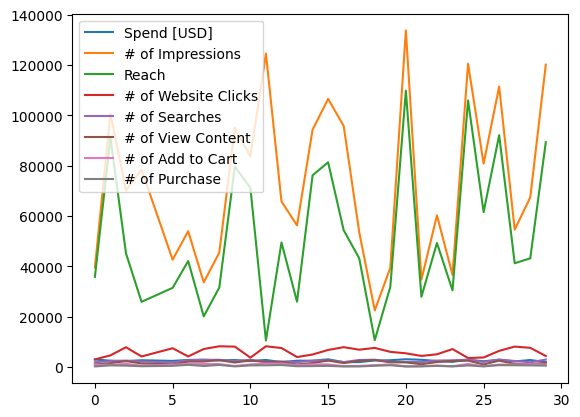

In [58]:
test_group[['Date',
               'Spend [USD]',
               '# of Impressions',
               'Reach',
               '# of Website Clicks',
               '# of Searches',
               '# of View Content',
               '# of Add to Cart',
               '# of Purchase'
               ]].plot();

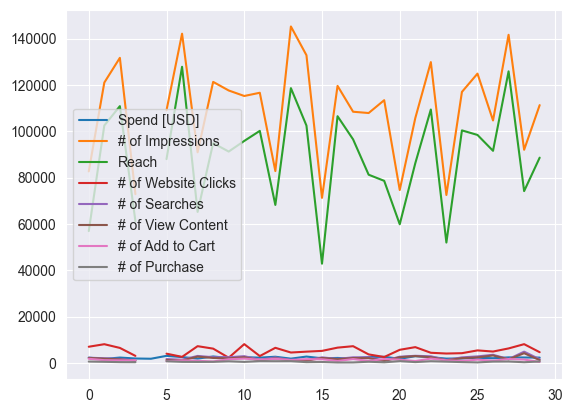

In [192]:
control_group[['Date',
               'Spend [USD]',
               '# of Impressions',
               'Reach',
               '# of Website Clicks',
               '# of Searches',
               '# of View Content',
               '# of Add to Cart',
               '# of Purchase'
               ]].plot();

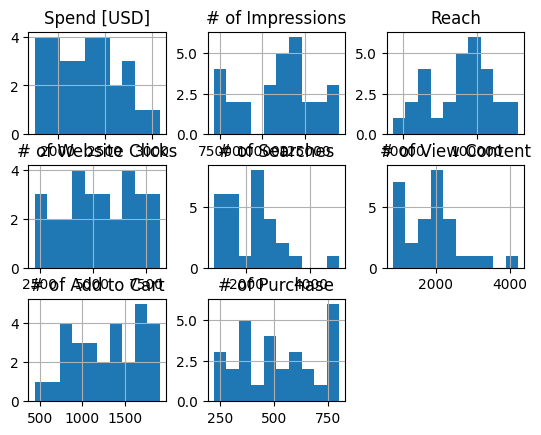

In [16]:
control_group[['Spend [USD]',
               '# of Impressions',
               'Reach',
               '# of Website Clicks',
               '# of Searches',
               '# of View Content',
               '# of Add to Cart',
               '# of Purchase'
               ]].hist();

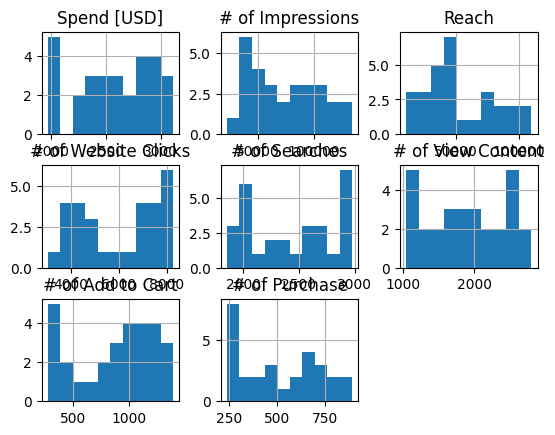

In [18]:
test_group[['Spend [USD]',
            '# of Impressions',
               'Reach',
               '# of Website Clicks',
               '# of Searches',
               '# of View Content',
               '# of Add to Cart',
               '# of Purchase'
               ]].hist();

Так как в 5.08.2019 не было данных в таблице c control_group удалим запись за это число из обеих групп.

In [68]:
control_group = control_group.drop(labels=[4], axis=0)
test_group = test_group.drop(labels=[4], axis=0)

## Уровень статистической значимости
### В качестве ошибки 1 - ого рода возьмем $\alpha = 0.05$.

In [ ]:
alpha = 0.05

Перед тем, как проверить разделение на тестовую и контрольную группы после проведения эксперимента, проверим, является ли распределение каждой из выборок нормальным. Если да, - воспользуемся T-тестом Стьюдента, иначе критерий Манна-Уитни.

Нулевая гипотеза: выборка из нормального распределения;
Альтернативная гипотеза: выборка не из нормального распределения.

In [77]:
res_test = normaltest(test_group[["Spend [USD]","# of Website Clicks", "# of Searches", "# of Purchase","# of Impressions", "Reach", "# of View Content", "# of Add to Cart"]])
res_control = normaltest(control_group[["Spend [USD]","# of Website Clicks", "# of Searches", "# of Purchase","# of Impressions", "Reach", "# of View Content", "# of Add to Cart"]])
print(f'Тестовая выборка: p-value = {res_test.pvalue}')
print(f'Контрольная выборка: p-value = {res_control.pvalue}')

Тестовая выборка: p-value = [2.56569782e-01 2.59367771e-04 1.54538202e-04 1.61053920e-02
 1.35714708e-01 2.54723888e-01 2.50491926e-02 5.67726116e-02]
Контрольная выборка: p-value = [0.41419677 0.22257983 0.02768585 0.0557416  0.44450444 0.69359083
 0.06435395 0.23667718]


Исходя из значений p-value для каждой из метрик эксперимента, расположенной по столбцам, получилось, что нет оснований для принятия нулевой гипотезы для метрик "# of Website Clicks", "# of Searches" и "# of Purchase", в то время как для контрольной группы почти все данные распределены нормально с вероятностью большей 95%.

Используем t-test для обнаружения статистических различий для "Spend [USD]", "# of Impressions", "Reach", "# of View Content", "# of Add to Cart". Для "# of Website Clicks", "# of Searches" и "# of Purchase" используем Манна-Уитни.

Нулевая гипотеза: между выборками отсутствуют статистически значимые различия; 
Альтернативная гипотеза: различия между группами существуют.

In [79]:
ttest_ind(test_group[["Spend [USD]","# of Impressions", "Reach", "# of View Content", "# of Add to Cart"]], control_group[["Spend [USD]", "# of Impressions", "Reach", "# of View Content", "# of Add to Cart"]])

Ttest_indResult(statistic=array([ 2.85723062, -5.08615376, -5.55628024, -0.28536452, -4.20348896]), pvalue=array([5.98801655e-03, 4.39585360e-06, 7.91540590e-07, 7.76417709e-01,
       9.54935776e-05]))

In [80]:
_, p = mannwhitneyu(control_group[["# of Website Clicks", "# of Searches", "# of Purchase"]], test_group[["# of Website Clicks", "# of Searches", "# of Purchase"]])
p

array([0.13957562, 0.16162167, 0.81553546])

Исходя из значений p-value для каждой из метрик эксперимента, расположенной по столбцам, получилось, 
что нет оснований для опровержения нулевой гипотезы лишь для метрик "# of Website Clicks", "# of Searches", "# of View Content" и "# of Purchase".

## Цель эксперимента
### Цель эксперимента - провести A/B тестирование и понять, есть ли разница между моделями расчета «Средняя Ставка» и «Максимальная Ставка».

## Нулевая и альтернативная гипотезы
### $H_0$ = {Количество перешедших уникальных пользователей по ссылке не изменится при изменении модели расчета}
### $H_1$ = {Количество перешедших уникальных пользователей по ссылке изменится при изменении модели расчета}

## Определение изменения и целевые метрики

### **IRR(impression-reach rate)** - это метрика показывает долю уникальных пользователей, перешедших по ссылке к общему числу пользователей

$$ IRR = \frac{Total~Reach~Count}{Total~Impressions~Count} \cdot 100 $$

### **CTR(click-through rate)** - это метрика показывает конверсию рекламы, то есть отношение числа кликов к числу показов.

$$ CTR = \frac{Total~Clicks~on~Website}{Total~Impressions~Count} \cdot 100 $$

### **CPC (cost per click)** - это метрика показывает сколько стоит один клик по рекламе.

$$ CPC = \frac{Total~Advertising~Spend}{Total~Clicks~on~Website}$$

### **Reach** - это метрика показывает сколько всего людей посмотрело рекламу.

### **CR (сonversion rate)** - это метрика показывает конверсию страницы (какая часть пользователей, которые перешли по рекламе, потом купили товары).

$$ CR = \frac{Total~Purchases~Count}{Total~Clicks~on~Website} \cdot 100 $$

### **Impressions** - это метрика показывает сколько всего раз реклама была показана.

### **CAC** - это стоимость привлечения клиента.

$$ CAC = \frac{Total~Advertising~Spend}{Total~Clicks~on~Website} $$

### **ATC Rate** - это доля посетителей, добавившее товары в корзину к общему число перешедших на сайт.

$$ ATC = \frac{Total~Add~to~Cart~Actions}{Total~Clicks~on~Website} $$

### **CPO (cost per order)** - цена за заказ.

$$ CPO = \frac{Total~Advertising~Spend}{Total~Purchases~Count} $$


# Расчет метрик

In [20]:
# control_group
IRR_cg = control_group['Reach'] * 100 / control_group['# of Impressions']
IRR_cg.name = 'IRR_cg'
CTR_cg = control_group['# of Website Clicks'] * 100 / control_group['# of Impressions']
CTR_cg.name = 'CTR_cg'
CPC_cg = control_group['Spend [USD]'] / control_group['# of Website Clicks']
CPC_cg.name = 'CPC_cg'
Reach_cg = control_group['Reach']
Reach_cg.name = 'Reach_cg'
CR_cg = control_group['# of Purchase'] * 100 / control_group['# of Website Clicks']
CR_cg.name = 'CR_cg'
CAC_cg = control_group['Spend [USD]'] / control_group['# of Website Clicks']
CAC_cg.name = 'CAC_cg'
ATC_cg = control_group['# of Add to Cart'] / control_group['# of Website Clicks']
ATC_cg.name = 'ATC_cg'
CPO_cg = control_group['Spend [USD]'] / control_group['# of Purchase']
CPO_cg.name = 'CPO_cg'
# test_group
IRR_tg = test_group['Reach'] * 100 / test_group['# of Impressions']
IRR_tg.name = 'IRR_tg'
CTR_tg = test_group['# of Website Clicks'] * 100 / test_group['# of Impressions']
CTR_tg.name = 'CTR_tg'
CPC_tg = test_group['Spend [USD]'] / test_group['# of Website Clicks']
CPC_tg.name = 'CPC_tg'
Reach_tg = test_group['Reach']
Reach_tg.name = 'Reach_tg'
CR_tg = test_group['# of Purchase'] * 100 / test_group['# of Website Clicks']
CR_tg.name = 'CR_tg'
CAC_tg = test_group['Spend [USD]'] / test_group['# of Website Clicks']
CAC_tg.name = 'CAC_tg'
ATC_tg = test_group['# of Add to Cart'] / test_group['# of Website Clicks']
ATC_tg.name = 'ATC_tg'
CPO_tg = test_group['Spend [USD]'] / test_group['# of Purchase']
CPO_tg.name = 'CPO_tg'

In [29]:
frames_cg = [control_group['Date'], IRR_cg, CTR_cg, CPC_cg, Reach_cg, CR_cg, CAC_cg, ATC_cg, CPO_cg]
metrics_cg = pd.concat(frames_cg, axis=1)
frames_tg = [test_group['Date'], IRR_tg, CTR_tg, CPC_tg, Reach_tg, CR_tg, CAC_tg, ATC_tg, CPO_tg]
metrics_tg = pd.concat(frames_tg, axis=1)

# Проверка нормальности метрик

## Критерий Шапиро - Уилка
### $H_0$ = {выборка исходит из нормального распределения.}

### ${H_1}$ = {выборка не соответствует нормальному распределению.}

In [30]:
[(i, stats.shapiro(metrics_cg[i]).pvalue) for i in metrics_cg.columns[1:] if stats.shapiro(metrics_cg[i]).pvalue > alpha]

[('IRR_cg', 0.05441483482718468),
 ('CTR_cg', 0.2448062300682068),
 ('Reach_cg', 0.6480628252029419)]

In [31]:
[(i, stats.shapiro(metrics_tg[i]).pvalue) for i in metrics_tg.columns[1:] if stats.shapiro(metrics_tg[i]).pvalue > alpha]

[('Reach_tg', 0.06648466736078262), ('ATC_tg', 0.12611566483974457)]

# Построение QQ - plots

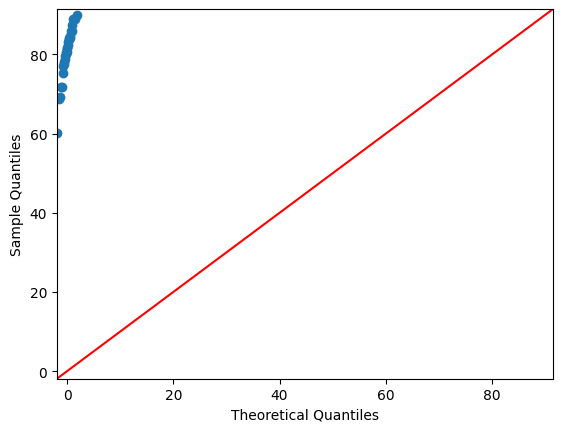

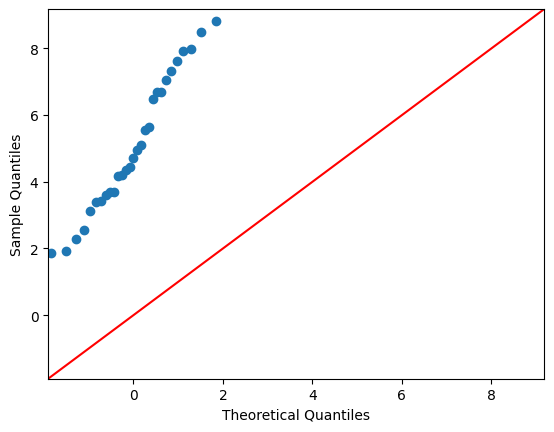

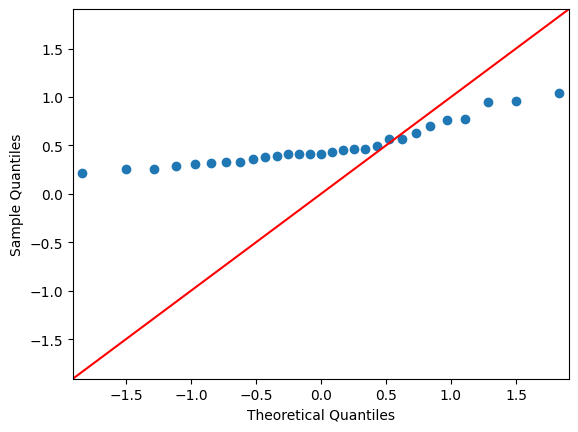

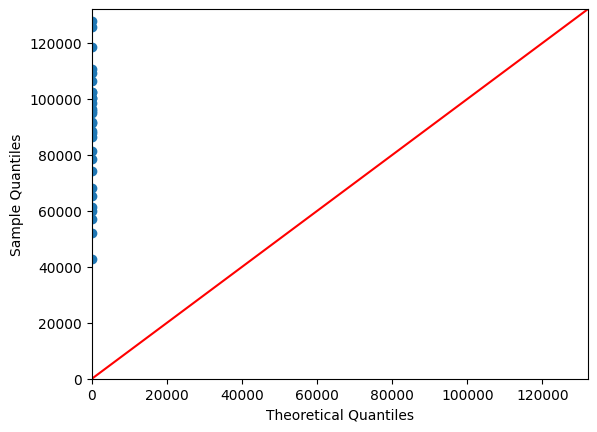

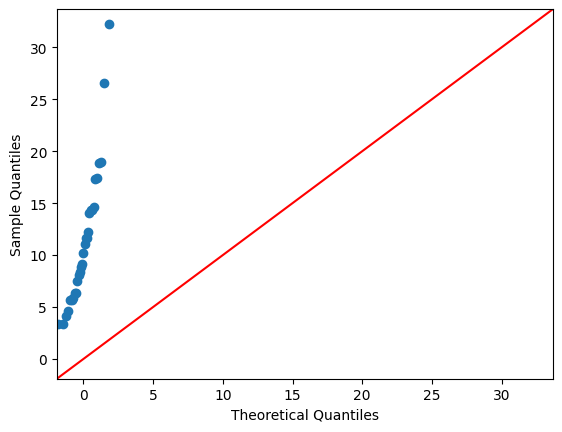

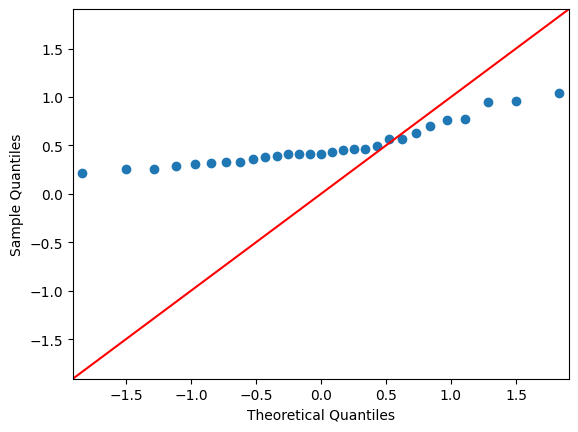

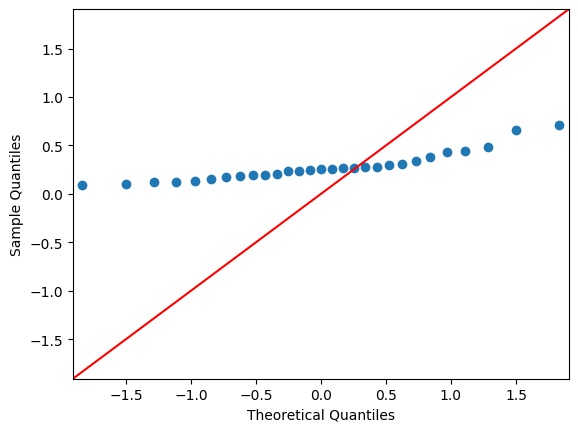

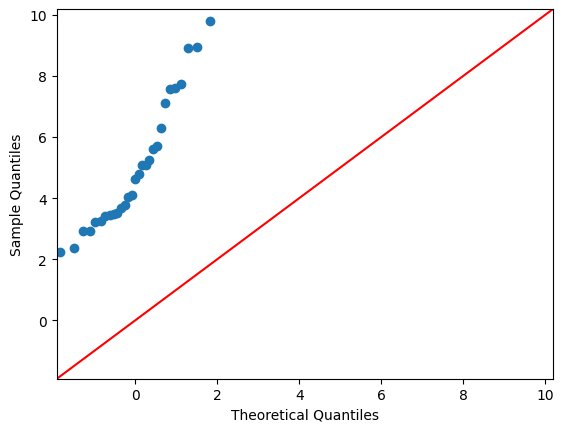

In [26]:
fig = [sm.qqplot(metrics_cg[i], line='45') for i in metrics_cg.columns[1:]]
plt.show()

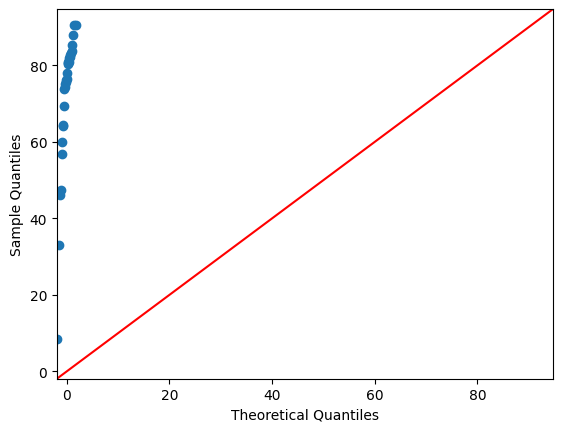

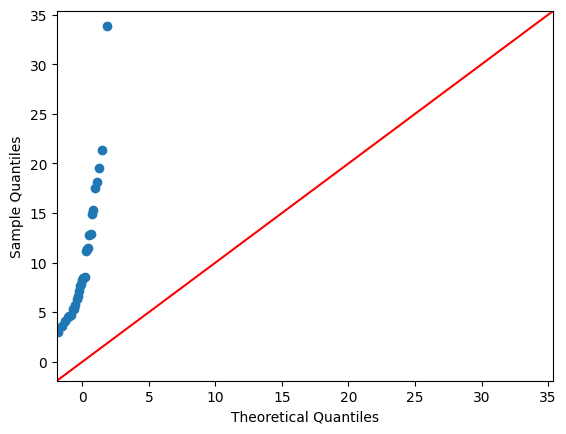

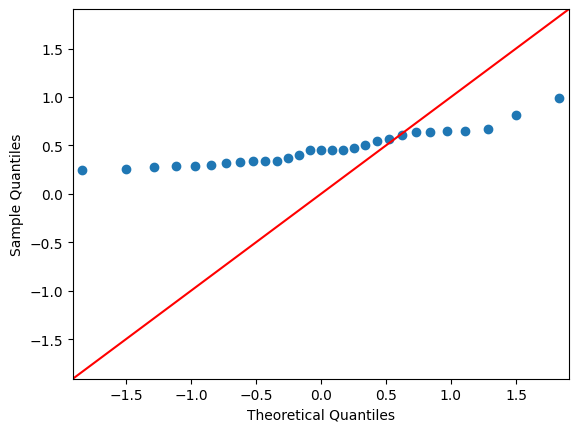

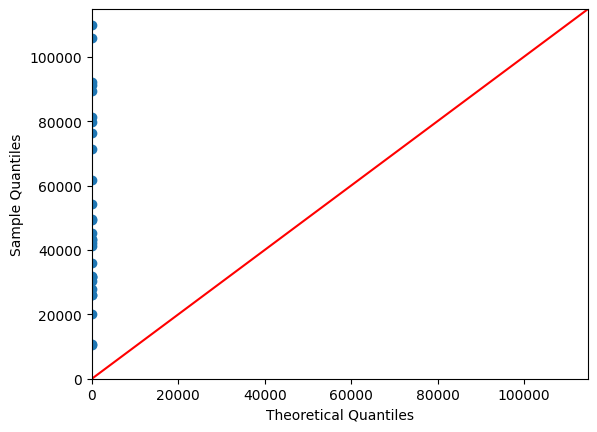

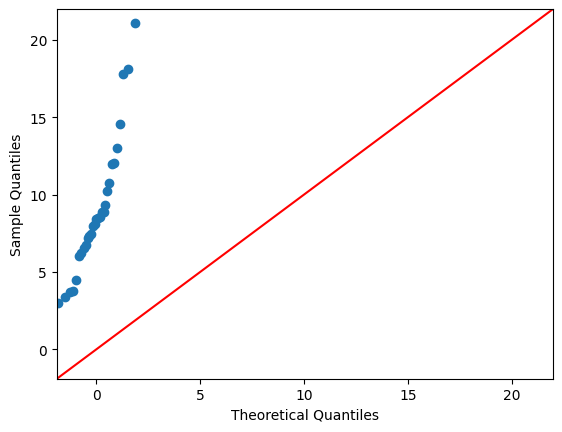

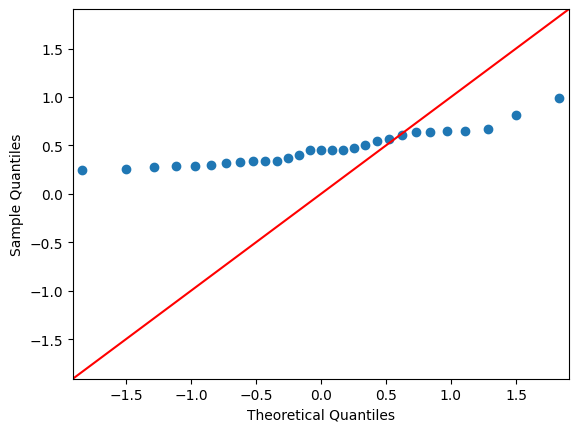

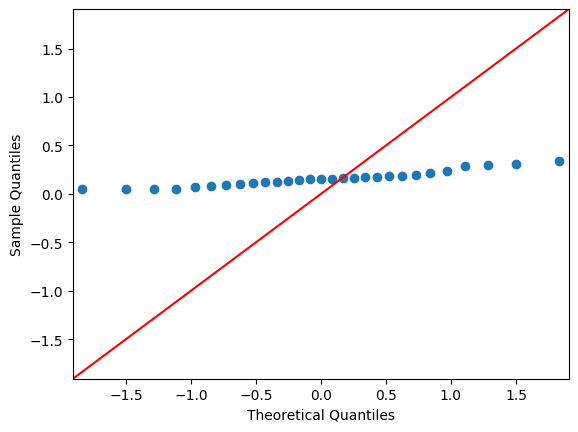

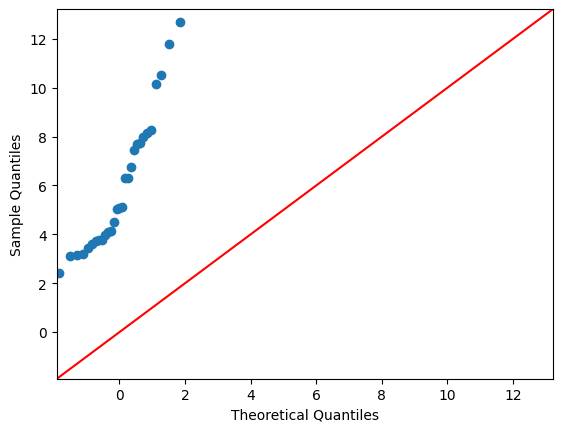

In [27]:
fig2 = [sm.qqplot(metrics_tg[i], line='45') for i in metrics_tg.columns[1:]]
plt.show()

## U-тест Манна-Уитни
### $H_0$ = {Распределения выборок равны.}
### ${H_1}$ = {Распределения выборок не равны.}
### Также тест поможет понять репрезентативность выборок. Считается, что если независимые выборки совпадают (не различаются значимо), то они являются репрезентативными.

In [32]:
for i, j in zip(metrics_cg.columns[1:], metrics_tg.columns[1:]):
    stat, p = stats.mannwhitneyu(metrics_cg[i], metrics_tg[j])
    if p > alpha:
        print(i, j, p)

CPC_cg CPC_tg 0.8641732313428653
CR_cg CR_tg 0.26284444131653684
CAC_cg CAC_tg 0.8641732313428653
CPO_cg CPO_tg 0.19678772302989056


Получившиеся выборки метрик являеются репрезентативными, поэтому мы можем использовать их для бутстрапирования.

# Bootstrap - метод получения критических значений статистики.
Идея метода: имеющаяся выборка - это единственная инфрмация об истинном распределении данных. Давайте приблизим истинное распределение эмпирическим, то есть "сами себя вытащим". Предполагается, что бутстрап-распределение окажется похожим на реальное распеделение.
Нужно, чтобы выборка была репрезентативной. Всего вариантов выборок n^n. Выход: симуляции.

Если распределение выборки несимметрично, такой доверительный интервал усиливает смещение, присущее изначальной выборке

Применим к каждой из метрик: CPC, CR, CAC, CPO метод бутстрапа.

# CPC

In [234]:
(np.median(metrics_cg['CPC_cg']), np.median(metrics_tg['CPC_tg']))

(0.41712204007285975, 0.4494203228006365)

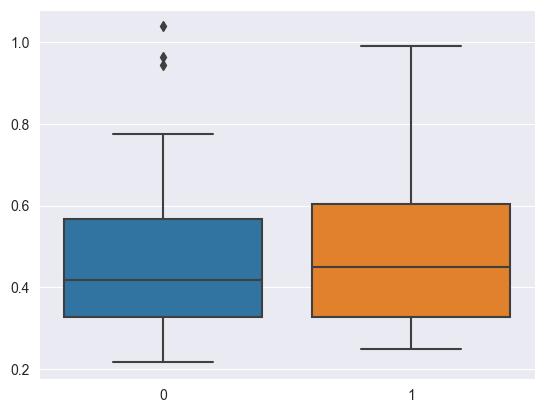

In [235]:
sns.boxplot([metrics_cg['CPC_cg'], metrics_tg['CPC_tg']]);

Проверяем гипотезу о равенстве 2 получившихся медиан с помощью бутстрепа. На гистограммах в контрольной группе наблюдаются выбросы, поэтому смотреть на среднее между двумя выборками будет некорректно, будем смотреть на медианы. Построим доверительный интервал для разности медиан.

In [236]:
def get_bootstap_sample(x, B_sample=1):
    N = x.size
    sample = np.random.choice(x, size=(N, B_sample), replace=True)

    if B_sample == 1:
        sample = sample.T[0]
    return sample

In [237]:
def stat_intervals(boot, alpha=alpha):
    left = np.quantile(boot, alpha / 2)
    right = np.quantile(boot, 1 - alpha / 2)
    return left, right

In [245]:
x_boot_cpc = get_bootstap_sample(metrics_cg['CPC_cg'], B_sample=10**5)
x_boot_cpc = np.median(x_boot_cpc, axis=0)

y_boot_cpc = get_bootstap_sample(metrics_tg['CPC_tg'], B_sample=10**5)
y_boot_cpc = np.median(y_boot_cpc, axis=0)

In [246]:
stat_intervals(x_boot_cpc)

(0.3850803244790838, 0.49892657793044226)

In [247]:
stat_intervals(y_boot_cpc)

(0.3433846153846154, 0.5458449645694653)

C:\Users\user\PycharmProjects\pythonProject3\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


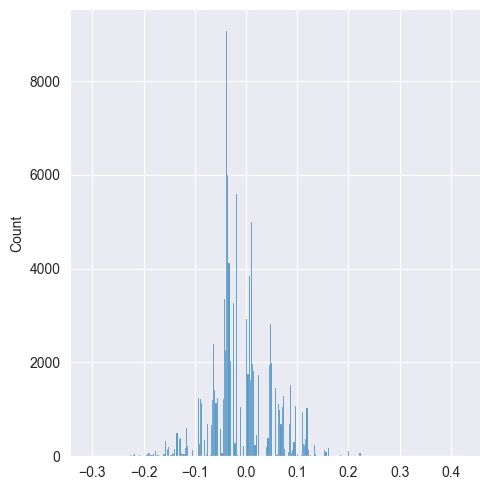

In [248]:
sns.displot(x_boot_cpc - y_boot_cpc);

In [249]:
stat_intervals(x_boot_cpc - y_boot_cpc)

(-0.13111371042215275, 0.1165660717571867)

Доверительный интервал покрывает 0, значит на уровне значимости 5% принимаем гипотезу о равенстве медиан выборок.

# CR

In [243]:
(np.median(metrics_cg['CR_cg']), np.median(metrics_tg['CR_tg']))

(10.227453475425481, 8.393680052666229)

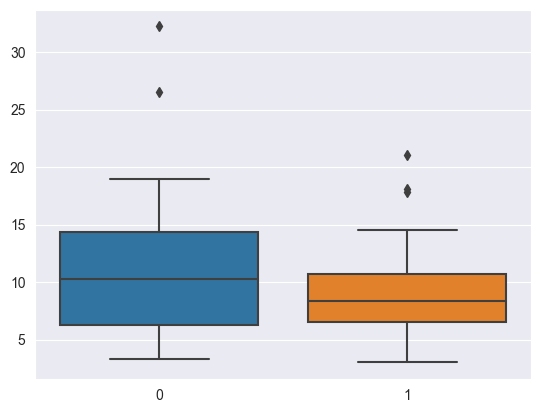

In [244]:
sns.boxplot([metrics_cg['CR_cg'], metrics_tg['CR_tg']]);

Опять же, в выборка есть выбросы, будем сравнивать медианы.

In [250]:
x_boot_cr = get_bootstap_sample(metrics_cg['CR_cg'], B_sample=10**5)
x_boot_cr = np.median(x_boot_cr, axis=0)

y_boot_cr = get_bootstap_sample(metrics_tg['CR_tg'], B_sample=10**5)
y_boot_cr = np.median(y_boot_cr, axis=0)

In [251]:
stat_intervals(x_boot_cr)

(7.4754901960784315, 14.057283429977156)

In [252]:
stat_intervals(y_boot_cr)

(7.161764705882353, 9.316525507189285)

C:\Users\user\PycharmProjects\pythonProject3\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


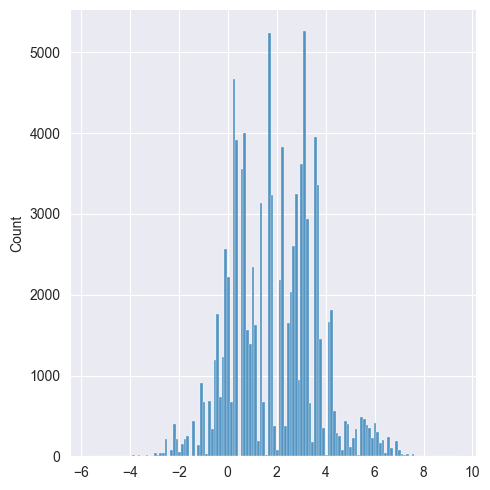

In [253]:
sns.displot(x_boot_cr - y_boot_cr);

In [254]:
stat_intervals(x_boot_cr - y_boot_cr)

(-1.1145883253109936, 5.6636033773109276)

Доверительный интервал покрывает 0. Принимаем нулевую гипотезу.

# CAC

In [255]:
(np.median(metrics_cg['CAC_cg']), np.median(metrics_tg['CAC_tg']))

(0.41712204007285975, 0.4494203228006365)

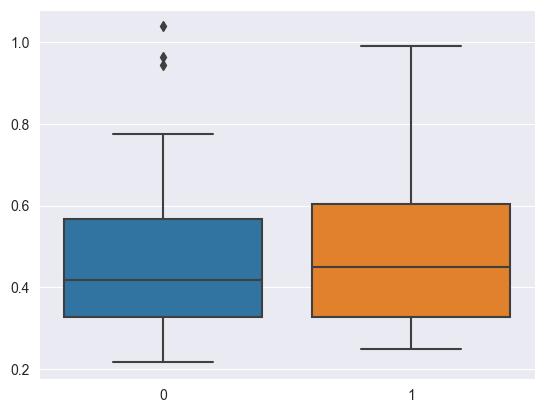

In [256]:
sns.boxplot([metrics_cg['CAC_cg'], metrics_tg['CAC_tg']]);

In [257]:
x_boot_cac = get_bootstap_sample(metrics_cg['CAC_cg'], B_sample=10**5)
x_boot_cac = np.median(x_boot_cac, axis=0)

y_boot_cac = get_bootstap_sample(metrics_tg['CAC_tg'], B_sample=10**5)
y_boot_cac = np.median(y_boot_cac, axis=0)

In [258]:
stat_intervals(x_boot_cac)

(0.3850803244790838, 0.49892657793044226)

In [259]:
stat_intervals(y_boot_cac)

(0.3433846153846154, 0.5458449645694653)

C:\Users\user\PycharmProjects\pythonProject3\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


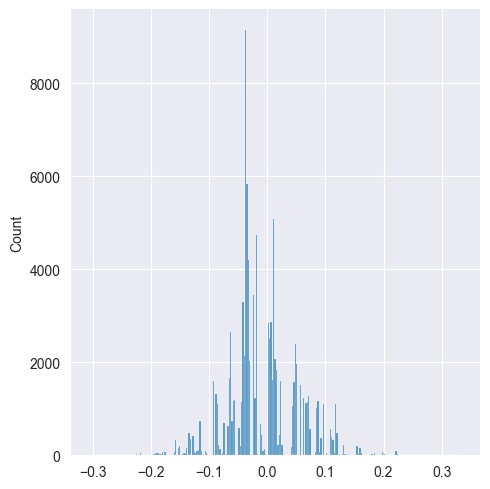

In [260]:
sns.displot(x_boot_cac - y_boot_cac);

In [261]:
stat_intervals(x_boot_cac - y_boot_cac)

(-0.12872292449660555, 0.11716464451962494)

Доверительный интервал покрывает 0. Принимаем нулевую гипотезу.

# CPO

In [266]:
(np.median(metrics_cg['CPO_cg']), np.median(metrics_tg['CPO_tg']))

(4.621004566210046, 5.088794926004228)

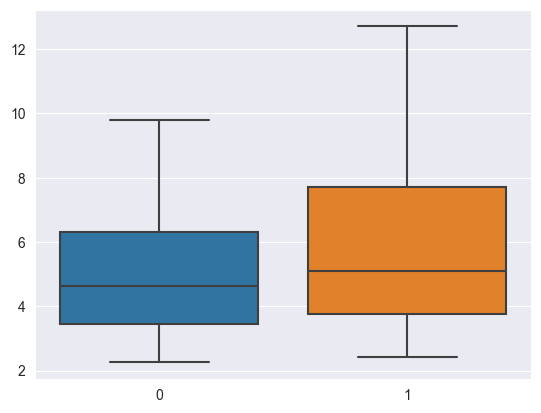

In [267]:
sns.boxplot([metrics_cg['CPO_cg'], metrics_tg['CPO_tg']]);

В данном случае нет заментых выбросов, можно сравнить группы по среднему

In [268]:
x_boot_cpo = get_bootstap_sample(metrics_cg['CPO_cg'], B_sample=10**5)
x_boot_cpo = np.mean(x_boot_cpo, axis=0)

y_boot_cpo = get_bootstap_sample(metrics_tg['CPO_tg'], B_sample=10**5)
y_boot_cpo = np.mean(y_boot_cpo, axis=0)

In [269]:
stat_intervals(x_boot_cpo)

(4.324480851595766, 5.825536372078695)

In [270]:
stat_intervals(y_boot_cpo)

(5.0348100963684175, 7.034986862439884)

C:\Users\user\PycharmProjects\pythonProject3\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


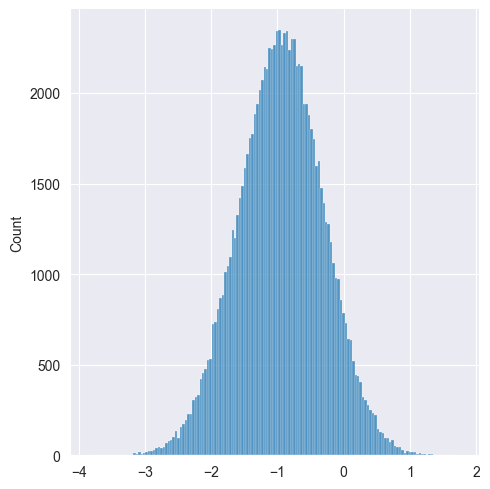

In [273]:
sns.displot(x_boot_cpo - y_boot_cpo);

In [272]:
stat_intervals(x_boot_cpo - y_boot_cpo)

(-2.2131473452373442, 0.29125798628990296)

Доверительный интервал покрывает 0. Принимаем нулевую гипотезу.

## Uplift
### В результате U-теста Манна-Уитни пройдемся по каждой метрике и найдем её uplift - оценка после изменения модели ставок (разница между средним контрольной и тестовой выборками)

In [35]:
uplift = [np.mean(CPC_cg) - np.mean(CPC_tg),
          np.mean(CR_cg) - np.mean(CR_tg),
          np.mean(CAC_cg) - np.mean(CAC_tg),
          np.mean(CPO_cg) - np.mean(CPO_tg),
          np.mean(Reach_cg) - np.mean(Reach_tg)]
uplift

[0.023536968294100402,
 2.379397879432295,
 0.023536968294100402,
 -0.947550879475882,
 36789.448275862065]

CP значимо увеличился, CPO уменьшился

## Двухвыборочный критерий Стьюдента
### $H_0$ = {Средние значения выборок равны.}
### ${H_1}$ = {Средние значения выборок не равны.}

In [33]:
stats.ttest_ind(Reach_cg, Reach_tg)

Ttest_indResult(statistic=5.556280238502353, pvalue=7.915405904037682e-07)

Обнаружили статистически значимые различия в среднем количестве уникальных пользователей, посмотревших рекламное объявление.

## Оценка значений ошибок первого и второго рода

In [57]:
effect = uplift[4]
values = Reach_tg
sample_size = Reach_tg.shape[0]


def run_synthetic_experiments(values, sample_size, effect=0, n_iter=10000):
    """Проводим синтетические эксперименты, возвращаем список p-value."""
    pvalues = []
    for _ in range(n_iter):
        a, b = np.random.choice(values, size=(2, sample_size,), replace=True)
        b = b + effect
        pvalue = stats.ttest_ind(a, b).pvalue
        pvalues.append(pvalue)
    return np.array(pvalues)

def print_estimated_errors(pvalues_aa, pvalues_ab, alpha):
    """Оценивает вероятности ошибок."""
    estimated_first_type_error = np.mean(pvalues_aa < alpha)
    estimated_second_type_error = np.mean(pvalues_ab >= alpha)
    ci_first = estimate_ci_bernoulli(estimated_first_type_error, len(pvalues_aa))
    ci_second = estimate_ci_bernoulli(estimated_second_type_error, len(pvalues_ab))
    print(f'оценка вероятности ошибки I рода = {estimated_first_type_error:0.4f}')
    print(f'  доверительный интервал = [{ci_first[0]:0.4f}, {ci_first[1]:0.4f}]')
    print(f'оценка вероятности ошибки II рода = {estimated_second_type_error:0.4f}')
    print(f'  доверительный интервал = [{ci_second[0]:0.4f}, {ci_second[1]:0.4f}]')

def estimate_ci_bernoulli(p, n, alpha=0.05):
    """Доверительный интервал для Бернуллиевской случайной величины."""
    t = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    std_n = np.sqrt(p * (1 - p) / n)
    return p - t * std_n, p + t * std_n

pvalues_aa = run_synthetic_experiments(values, sample_size, effect=0)
pvalues_ab = run_synthetic_experiments(values, sample_size, effect=effect)
print_estimated_errors(pvalues_aa, pvalues_ab, alpha)

оценка вероятности ошибки I рода = 0.0500
  доверительный интервал = [0.0457, 0.0543]
оценка вероятности ошибки II рода = 0.0015
  доверительный интервал = [0.0007, 0.0023]


## Тепловая карта корреляций

### С помощью тепловой карты корреляций также можно узнать, какие ключевые метрики выросли благодаря признакам, на которые косвенно воздействовали смена модели атрибуции.

In [9]:
control_numgroup = control_group.drop(["Campaign Name", "Date"], axis=1)
test_numgroup = test_group.drop(["Campaign Name", "Date"], axis=1)

correlation_matrix_control = control_numgroup.corr()
correlation_matrix_test = test_numgroup.corr()

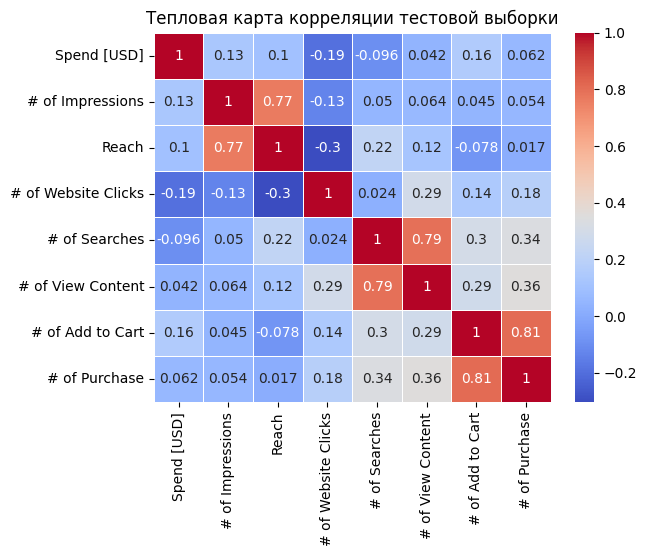

In [10]:
sns.heatmap(correlation_matrix_test, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Тепловая карта корреляции тестовой выборки')
plt.show()

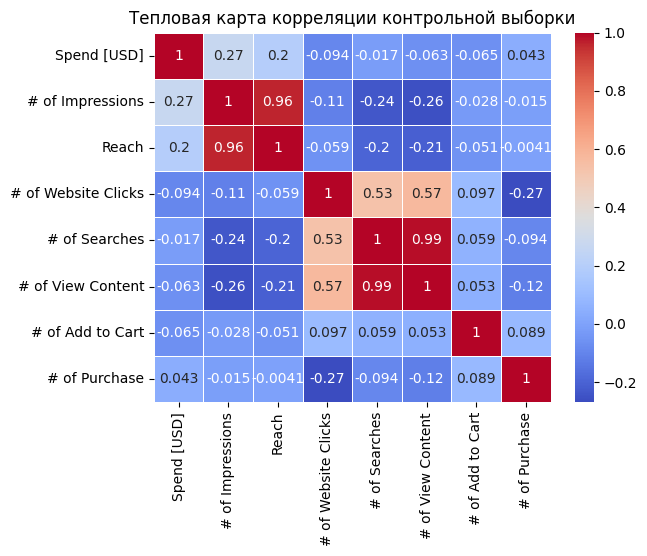

In [11]:
sns.heatmap(correlation_matrix_control, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Тепловая карта корреляции контрольной выборки')
plt.show()